In [26]:
import sys
sys.path.append("/home/rossidaniel/Documenti/bin-packing/Python/")
sys.path.append("/home/rossidaniel/Documenti/bin-packing/")

In [27]:
import Bin_Packing_Py as BP
import BP_print
import BP_plot
import BP_utilities
import HA_routines
import BP_instances

import matplotlib
%matplotlib nbagg
matplotlib.rcParams['figure.figsize'] = [6,3.5]

from ortools.linear_solver import pywraplp
import random
import time

In [28]:
class model_bin_packing:
    def __init__(self,bin_h, bin_d, bin_w, n_items):
        self.bp = BP.BinPack()
        item_list, bin_list =BP_instances.tc_1(n_items)
        self.bp.items.extend(item_list)
        self.bp.bins.extend(bin_list)
    
    def buildModel(self,amount_time=300000):
        solver = pywraplp.Solver('Model2DR', pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
        
        #importo dimensioni dei pacchi e del camion
        n=len(self.bp.items)

        w =[self.bp.items[i].width for i in range(n)]
        d =[self.bp.items[i].depth for i in range(n)]
        h =[self.bp.items[i].height for i in range(n)]
        
        W =self.bp.bins[0].width
        D =solver.NumVar(0,sum(h),"D")
        H =self.bp.bins[0].height
        
        Md=sum(d)
        Mw=W+min(w)
        Mz=sum(h)

        # definisco le variabili
        l =[[solver.BoolVar("l%d%d" % (i,j)) for i in range(n)] for j in range(n)]
        b =[[solver.BoolVar("b%d%d" % (i,j)) for i in range(n)] for j in range(n)]
        t =[[solver.BoolVar("t%d%d" % (i,j)) for i in range(n)] for j in range(n)]
        r =[solver.BoolVar("r%d" % (i)) for i in range(n)]

        x =[solver.NumVar(0,solver.infinity(),"x%d" % i) for i in range(n)]
        y =[solver.NumVar(0,solver.infinity(),"y%d" % i) for i in range(n)]
        z =[solver.IntVar(0,solver.infinity(),"z%d" % i) for i in range(n)]


        #definisco i constraints
        for i in range(n):
            for j in range(n):
                if(i < j):
                    solver.Add(l[i][j] + l[j][i] + b[i][j] + b[j][i] + t[i][j] + t[j][i] >= 1)
                if(i != j):
                    solver.Add(x[i] - x[j] + Mw * l[i][j] <= Mw - w[i]*(1-r[i]) - d[i]*r[i])
                    solver.Add(y[i] - y[j] + Md * b[i][j] <= Md - d[i]*(1-r[i]) - w[i]*r[i])
                    
                    solver.Add(x[i] - x[j] + Mw * t[i][j] <= Mw)
                    solver.Add(y[i] - y[j] + Md * t[i][j] <= Md)
                    
                    solver.Add(x[i] + w[i] - x[j] - w[j] + Mw * t[i][j] <= Mw)
                    solver.Add(y[i] + d[i] - y[j] - d[j] + Md * t[i][j] <= Md)
    
                    solver.Add(z[i] - z[j] + Mz * t[i][j] <= Mz - h[i])
                    solver.Add(z[i] - z[j] + Mz >= Mz * t[i][j] - h[i])
                    
            solver.Add(x[i] + w[i]*(1-r[i]) + d[i]*r[i] <= W)
            solver.Add(y[i] + d[i]*(1-r[i]) + w[i]*r[i] <= D)
            solver.Add(z[i] + h[i] <= H)

        for j in range(n):
            solver.Add(solver.Sum([t[i][j] for i in range(n) if i!=j])*Mz >= z[j])
        
        #funzione obiettivo
        objective = solver.Objective()
        objective.SetCoefficient(D,1)
        objective.SetMinimization()

        #soluzione
        solver.SetTimeLimit(amount_time)
        solver.Solve()

        s = BP.Solution(self.bp)
        for i in range(len(self.bp.items)):
            rt = False if r[i].solution_value() == 0 else True
            s.pushItem(self.bp.items[i],0,BP.Point(x[i].solution_value(), y[i].solution_value(),z[i].solution_value()),rt,False)
        return s
    
    def BuildSolution(self,s):
        print s
        BP_plot.plotSolution(s)
        BP_plot.plot3DSolution(s,0)


In [29]:
model = model_bin_packing(2.50,4,2.70,7)

In [30]:
s=model.buildModel()


BIN: (w,d,h) = (2.5,13.5,2.7)
[Anchors]:
Point: (x,y,z) = (0.0,0.8,0.0), Item: [0 (1)] (w,d,h) = (1.2,0.8,0.5), weight = 5.0 [R] 
Point: (x,y,z) = (0.0,2.0,0.0), Item: [1 (1)] (w,d,h) = (1.2,0.8,0.5), weight = 5.0
Point: (x,y,z) = (0.8,0.8,0.0), Item: [2 (1)] (w,d,h) = (1.2,0.8,0.5), weight = 5.0 [R] 
Point: (x,y,z) = (0.0,0.0,0.0), Item: [3 (1)] (w,d,h) = (1.2,0.8,0.5), weight = 5.0
Point: (x,y,z) = (1.7,0.8,0.0), Item: [4 (1)] (w,d,h) = (1.2,0.8,0.5), weight = 5.0 [R] 
Point: (x,y,z) = (1.3,0.0,0.0), Item: [5 (1)] (w,d,h) = (1.2,0.8,0.5), weight = 5.0
Point: (x,y,z) = (1.3,2.0,0.0), Item: [6 (1)] (w,d,h) = (1.2,0.8,0.5), weight = 5.0
-----------
[Extreme Points]:
(x,y,z) = (0.0,0.0,0.0)
-----------

BIN: (w,d,h) = (0.0,0.0,0.0)
[Anchors]:

-----------
[Extreme Points]:
(x,y,z) = (0.0,0.0,0.0)
-----------

Feasibility: True 
Obj: 0.0


<IPython.core.display.Javascript object>


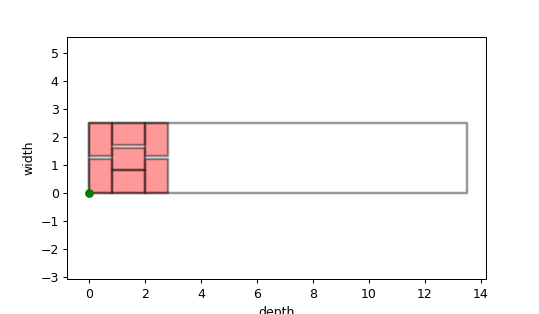

<IPython.core.display.Javascript object>


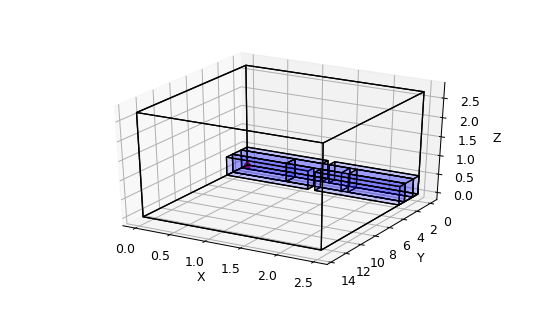

In [31]:
model.BuildSolution(s)